# Blight violations in the city of Detroit

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Applied_Data_Science_with_Python_Specialization/portfolio-4.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Predict whether a given blight ticket will be paid on time.

[Blight violations](https://data.detroitmi.gov/datasets/detroitmi::blight-violations/about) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process.

Each row of the dataset corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible.

**Notes**: 
- All tickets where the violators were found not responsible are not considered.

File descriptions:

- train.csv -> the dataset (all tickets issued 2004-2011)
- addresses.csv & latlons.csv -> mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 

Data fields:

- ticket_id -> unique identifier for tickets
- agency_name -> Agency that issued the ticket
- inspector_name -> Name of inspector that issued the ticket
- violator_name -> Name of the person/organization that the ticket was issued to
- violation_street_number, violation_street_name, violation_zip_code -> Address where the violation occurred
- mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country -> Mailing address of the violator
- ticket_issued_date -> Date and time the ticket was issued
- hearing_date -> Date and time the violator's hearing was scheduled
- violation_code, violation_description -> Type of violation
- disposition -> Judgment and judgement type
- fine_amount -> Violation fine amount, excluding fees
- admin_fee -> $20 fee assigned to responsible judgments
- state_fee -> $10 fee assigned to responsible judgments
- late_fee -> 10% fee assigned to responsible judgments
- discount_amount -> discount applied, if any
- clean_up_cost -> DPW clean-up or graffiti removal cost
- judgment_amount -> Sum of all fines and fees
- grafitti_status -> Flag for graffiti violations
- payment_amount -> Amount paid, if any
- payment_date -> Date payment was made, if it was received
- payment_status -> Current payment status as of Feb 1 2017
- balance_due -> Fines and fees still owed
- collection_status -> Flag for payments in collections
- compliance [target variable for prediction] 
    - Null = Not responsible
    - 0 = Responsible, non-compliant
    - 1 = Responsible, compliant
- compliance_detail -> More information on why each ticket was marked compliant or non-compliant

## Download the data

In [1]:
%%bash

wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Applied_Data_Science_with_Python_Specialization/main/Applied_Machine_Learning_in_Python/Week4/Labs/data/train.csv.gz
wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Applied_Data_Science_with_Python_Specialization/main/Applied_Machine_Learning_in_Python/Week4/Labs/data/addresses.csv.gz
wget -q https://raw.githubusercontent.com/LuisAngelMendozaVelasco/Applied_Data_Science_with_Python_Specialization/main/Applied_Machine_Learning_in_Python/Week4/Labs/data/latlons.csv
gunzip ./*.gz

## Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  ConfusionMatrixDisplay, classification_report, roc_auc_score
import folium

## Load the data

In [3]:
df_original_data = pd.read_csv('./train.csv', encoding="ISO-8859-1", low_memory=False)
df_original_data.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
3,22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MOROSI, MIKE",1441.0,LONGFELLOW,NaN,5.0,ST. CLAIR,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN
4,22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","NATHANIEL, NEAL",2449.0,CHURCHILL,NaN,7449.0,CHURCHILL,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


In [4]:
df_addresses = pd.read_csv('./addresses.csv')
df_addresses

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"
...,...,...
311302,376496,"12032 santa rosa, Detroit MI 48204"
311303,376497,"12032 santa rosa, Detroit MI 48204"
311304,376499,"11832 kilbourne, Detroit MI 48213"
311305,376500,"11848 kilbourne, Detroit MI 48213"


In [5]:
df_latlons = pd.read_csv('./latlons.csv')
df_latlons

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295
...,...,...,...
121764,"14267 sorrento, Detroit MI",42.392339,-83.172412
121765,"9359 vaughan, Detroit MI",42.363781,-83.237494
121766,"5911 courville, Detroit MI",42.409321,-82.943282
121767,"14545 wyoming, Detroit MI",42.395836,-83.159670


## Merge the data

In [6]:
df_addresses_latlons = df_addresses.merge(df_latlons, on="address")
df_merged_data = df_original_data.merge(df_addresses_latlons, on="ticket_id")

## Drop non-relevant features and missing values

In [7]:
df_reduced_data = df_merged_data[df_merged_data['country'] == "USA"]

drop_columns = ['ticket_id', 'inspector_name', 'violator_name', 'violation_street_number', 'violation_street_name', 'violation_zip_code', 
                'mailing_address_str_number', 'mailing_address_str_name', 'city', 'state', 'zip_code', 'non_us_str_code', 'country', 'ticket_issued_date', 
                'hearing_date', 'violation_description', 'violation_code', 'admin_fee', 'state_fee', 'clean_up_cost', 'grafitti_status', 'payment_amount', 
                'balance_due', 'payment_date', 'payment_status', 'collection_status', 'compliance_detail', 'address']
df_reduced_data = df_reduced_data.drop(drop_columns, axis=1).dropna()

## Print a summary of the reduced dataset

In [8]:
df_reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159867 entries, 0 to 250293
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   agency_name      159867 non-null  object 
 1   disposition      159867 non-null  object 
 2   fine_amount      159867 non-null  float64
 3   late_fee         159867 non-null  float64
 4   discount_amount  159867 non-null  float64
 5   judgment_amount  159867 non-null  float64
 6   compliance       159867 non-null  float64
 7   lat              159867 non-null  float64
 8   lon              159867 non-null  float64
dtypes: float64(7), object(2)
memory usage: 12.2+ MB


## Visualize the class distribution

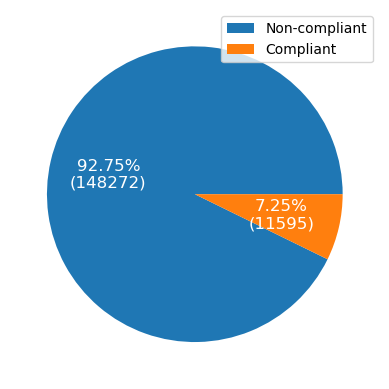

In [9]:
compliant = df_reduced_data["compliance"].sum()
non_compliant = len(df_reduced_data) - compliant
labels = ["Non-compliant", "Compliant"]
sizes = [non_compliant, compliant]

fig, ax = plt.subplots()
ax.pie(sizes, textprops={'fontsize': '12', 'color': 'w'}, autopct=lambda pct: "{:.2f}%\n({:d})".format(pct, round(pct/100 * sum(sizes))))
ax.legend(labels)
plt.show()

## Visualize a map of the city of Detroit with the location of some samples in the dataset

Red markers mean `Compliant`, while blue markers mean `Non-compliant`.

In [10]:
map = folium.Map(location=[42.33, -83.04], zoom_start=12)
feature_group = folium.FeatureGroup()
df_sample = df_reduced_data.sample(n=1000)

for point, compliance in zip(list(df_sample[["lat", "lon"]].to_numpy()), list(df_sample["compliance"])):
    if compliance == 1:
        feature_group.add_child(folium.Marker(point, popup='Compliant', icon=folium.Icon(color='red')))
    else:
        feature_group.add_child(folium.Marker(point, popup='Non-compliant', icon=folium.Icon(color='blue')))

map.add_child(feature_group)
map

## Convert categorical variable into indicator variables

In [11]:
df_encoded_data = pd.get_dummies(df_reduced_data, drop_first=True)

## Split the data into training and test sets

In [12]:
X = df_encoded_data.drop("compliance", axis=1)
y = df_encoded_data["compliance"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Perform a grid search for a Random Forest Classifier

In [13]:
n_estimators =  [75, 100, 125]
max_depth = [6, 9, 12]
parameters = {'n_estimators': n_estimators, 'max_depth': max_depth}

random_forest_classifier = RandomForestClassifier()
clf = GridSearchCV(random_forest_classifier, param_grid=parameters, scoring='recall')
clf.fit(X_train, y_train)

pd.DataFrame(clf.cv_results_['mean_test_score'].reshape(3, 3), columns=[f"n_estimators = {i}" for i in n_estimators], index=[f"max_depth = {i}" for i in max_depth])

,n_estimators = 75,n_estimators = 100,n_estimators = 125
max_depth = 6,0.252761,0.252415,0.252645
max_depth = 9,0.252415,0.252300,0.252646
max_depth = 12,0.252761,0.252761,0.252301


## Evaluate the best estimator chosen by the grid search

In [14]:
estimator = clf.best_estimator_
y_pred = estimator.predict(X_test)
y_pred_proba = estimator.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(classification_report(y_test, y_pred, digits=4))
print("Area Under the Receiver Operating Characteristic Curve (ROC AUC) = {:.4f}".format(roc_auc))

              precision    recall  f1-score   support

         0.0     0.9444    0.9981    0.9705     37064
         1.0     0.9108    0.2497    0.3920      2903

    accuracy                         0.9437     39967
   macro avg     0.9276    0.6239    0.6812     39967
weighted avg     0.9420    0.9437    0.9285     39967

Area Under the Receiver Operating Characteristic Curve (ROC AUC) = 0.8093


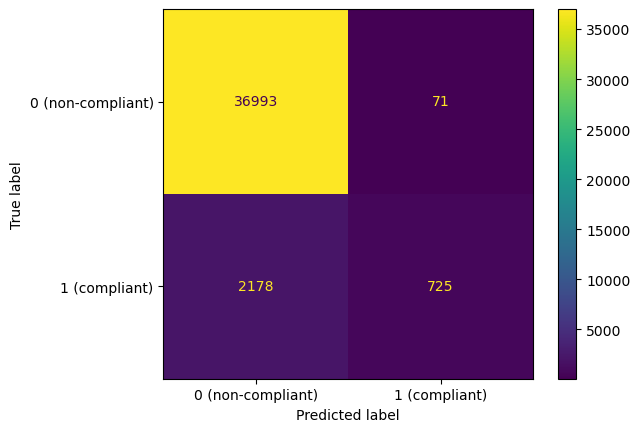

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0 (non-compliant)", "1 (compliant)"])
plt.show()

In [16]:
%%bash

rm ./*.csv